Erro ao processar linha: the data is based on the CARP instance gdb1.
Quantidade de vértices: 12
Quantidade de arestas: 11
Quantidade de arcos: 22
Caminho médio: 16.71
Densidade do grafo: 0.17
Diâmetro do grafo: 30


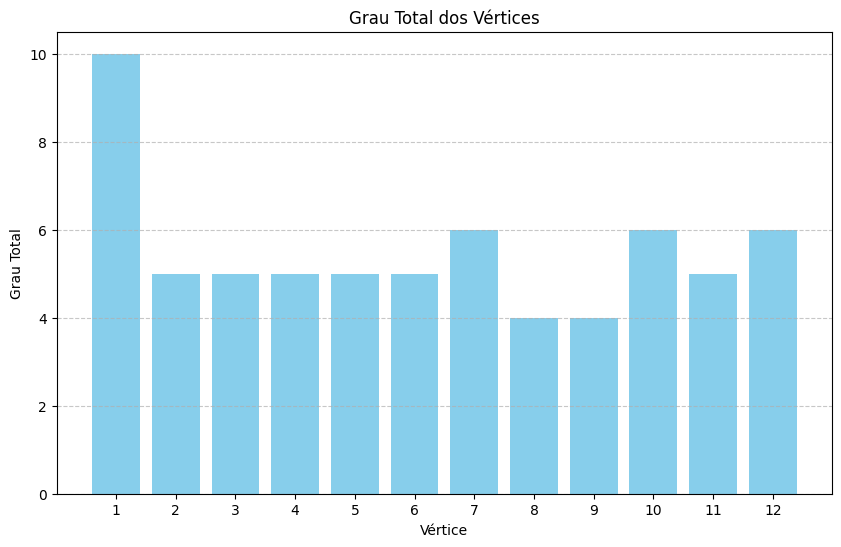

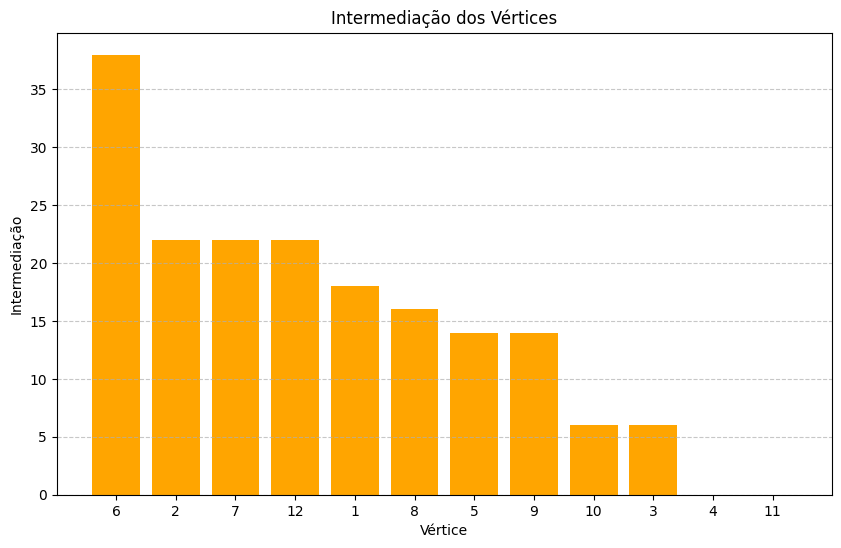

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

class Graph:
    def __init__(self):
        self.vertices = set()
        self.edges = set()
        self.arcs = set()
        self.required_vertices = set()
        self.required_edges = set()
        self.required_arcs = set()

    def load_from_file(self, path):
        try:
            with open(path, "r", encoding="utf-8") as file:
                lines = file.readlines()
        except FileNotFoundError:
            print(f"Arquivo '{path}' não encontrado.")
            return None
        except Exception as e:
            print(f"Erro ao ler o arquivo: {e}")
            return None

        section = None
        for line in lines:
            line = line.strip()
            if not line or line.startswith("//") or line.startswith("Name:"):
                continue

            # Detecta a seção
            if line.startswith("ReN."):
                section = "ReN"
                continue
            elif line.startswith("ReE."):
                section = "ReE"
                continue
            elif line.startswith("EDGE"):
                section = "EDGE"
                continue
            elif line.startswith("ReA."):
                section = "ReA"
                continue
            elif line.startswith("ARC"):
                section = "ARC"
                continue

            parts = line.split("\t")
            try:
                if section == "ReN":
                    node = int(parts[0].replace("N", ""))
                    demand, service_cost = int(parts[1]), int(parts[2])
                    self.vertices.add(node)
                    self.required_vertices.add((node, (demand, service_cost)))

                elif section in ["ReE", "EDGE"]:
                    u, v = int(parts[1]), int(parts[2])
                    cost = int(parts[3])
                    edge = (min(u, v), max(u, v))
                    self.vertices.update([u, v])
                    self.edges.add((edge, cost))

                    if section == "ReE":
                        demand, service_cost = int(parts[4]), int(parts[5])
                        self.required_edges.add((edge, (cost, demand, service_cost)))

                elif section in ["ReA", "ARC"]:
                    u, v = int(parts[1]), int(parts[2])
                    cost = int(parts[3])
                    arc = (u, v)
                    self.vertices.update([u, v])
                    self.arcs.add((arc, cost))

                    if section == "ReA":
                        demand, service_cost = int(parts[4]), int(parts[5])
                        self.required_arcs.add((arc, (cost, demand, service_cost)))
            except (ValueError, IndexError):
                print(f"Erro ao processar linha: {line}")
                continue

        return self if self.vertices else None


# --- Funções Auxiliares ---

def construir_grafo_dict(vertices, edges, arcs):
    graph = {v: [] for v in vertices}
    for (u, v), _ in edges:
        graph[u].append(v)
        graph[v].append(u)
    for (u, v), _ in arcs:
        graph[u].append(v)
    return graph


def floyd_warshall(vertices, edges, arcs):
    dist = {v: {u: float("inf") for u in vertices} for v in vertices}
    pred = {v: {u: None for u in vertices} for v in vertices}

    for v in vertices:
        dist[v][v] = 0

    for (u, v), cost in edges:
        dist[u][v] = dist[v][u] = cost
        pred[u][v], pred[v][u] = u, v

    for (u, v), cost in arcs:
        dist[u][v] = cost
        pred[u][v] = u

    for k in vertices:
        for i in vertices:
            for j in vertices:
                if dist[i][k] + dist[k][j] < dist[i][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]
                    pred[i][j] = pred[k][j]

    return dist, pred


def caminho_minimo(pred, origem, destino):
    if pred[origem][destino] is None:
        return []
    caminho = [destino]
    while origem != destino:
        destino = pred[origem][destino]
        caminho.insert(0, destino)
    return caminho


# --- Métricas ---

def caminho_medio(vertices, edges, arcs):
    dist, _ = floyd_warshall(vertices, edges, arcs)
    soma = total = 0
    for u in vertices:
        for v in vertices:
            if u != v and dist[u][v] != float("inf"):
                soma += dist[u][v]
                total += 1
    return soma / total if total else 0


def calc_densidade(n_arestas, n_arcos, n_vertices):
    max_edges = n_vertices * (n_vertices - 1) / 2
    max_arcs = n_vertices * (n_vertices - 1)
    return (n_arestas + n_arcos) / (max_edges + max_arcs)


def calc_diametro(distancias):
    return max(
        dist for orig in distancias for dest, dist in distancias[orig].items()
        if orig != dest and dist != float("inf")
    )


def calc_intermediacao(vertices, pred):
    intermediacao = {v: 0 for v in vertices}
    for u in vertices:
        for v in vertices:
            if u != v:
                caminho = caminho_minimo(pred, u, v)
                for inter in caminho[1:-1]:
                    intermediacao[inter] += 1
    return intermediacao


def calcular_graus(vertices, edges, arcs):
    graus = {v: [0, 0, 0] for v in vertices}
    for (u, v), _ in edges:
        graus[u][0] += 1
        graus[v][0] += 1
    for (u, v), _ in arcs:
        graus[u][2] += 1
        graus[v][1] += 1
    return graus


# --- Visualização ---

def plot_bar_chart(data, title, ylabel, color):
    df = pd.DataFrame(list(data.items()), columns=["Vértice", ylabel])
    df = df.sort_values("Vértice")

    plt.figure(figsize=(10, 6))
    plt.bar(df["Vértice"].astype(str), df[ylabel], color=color)
    plt.title(title)
    plt.xlabel("Vértice")
    plt.ylabel(ylabel)
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# --- Execução Principal ---

if __name__ == "__main__":
    caminho = input("Digite o nome do arquivo/caminho: ").strip()
    grafo = Graph().load_from_file(caminho)

    if grafo is None:
        print("Erro ao carregar o grafo.")
        exit()

    estrutura = construir_grafo_dict(grafo.vertices, grafo.edges, grafo.arcs)

    print("Quantidade de vértices:", len(grafo.vertices))
    print("Quantidade de arestas:", len(grafo.edges))
    print("Quantidade de arcos:", sum(1 for u in estrutura for v in estrutura[u] if u in estrutura.get(v, [])) // 2)
    print("Caminho médio:", round(caminho_medio(grafo.vertices, grafo.edges, grafo.arcs), 2))
    print("Densidade:", round(calc_densidade(len(grafo.edges), len(grafo.arcs), len(grafo.vertices)), 2))

    matriz_dist, matriz_pred = floyd_warshall(grafo.vertices, grafo.edges, grafo.arcs)
    print("Diâmetro:", calc_diametro(matriz_dist))

    graus = calcular_graus(grafo.vertices, grafo.edges, grafo.arcs)
    grau_total = {v: sum(g) for v, g in graus.items()}
    intermediacao = calc_intermediacao(grafo.vertices, matriz_pred)

    plot_bar_chart(grau_total, "Grau Total dos Vértices", "Grau Total", "skyblue")
    plot_bar_chart(intermediacao, "Intermediação dos Vértices", "Intermediação", "orange")
